In [ ]:
!pip install urizen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.4/171.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 17.4 MB/s eta 0:00:00


In [ ]:
import urizen as uz

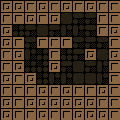

In [ ]:
# M = uz.dungeon_bsp_tree(50, 50)
M = uz.dungeon_drunkard(10, 10)

# And visualize it using Pillow with Urizen tileset
uz.vg_tiled(M, scale=1)

In [ ]:
from PIL import Image
Map = uz.building_ruined_house(w=9, h=9)
a = uz.vg_tiled(Map, scale=3, show=False, filepath=None)
a.save(fp='name.png', format=None)

In [ ]:
# vars(Map)
# vars(Map.cells[0][0].metatile)
Map.cells[0][0].metatile.get_tiles()
# vars(Map.cells[0][0].metatile.get_tiles()[0])

In [ ]:
uz.core.entity_collection.C.wall_dungeon_smooth

urizen.core.entity_collection.wall_dungeon_smooth

In [ ]:
TILESETS = [
  # 'urizen-onebit-basic',
  # 'urizen-onebit-fantasy-medieval',
  'urizen-onebit-modern',
  # 'urizen-onebit-fonts',
]

for tileset in TILESETS:
  cells, things, actors = uz.core.entity_collection._get_tileset_tiles(tileset)
  uz.core.entity_collection.cell_metatiles.update(cells)
  uz.core.entity_collection.thing_metatiles.update(things)
  uz.core.entity_collection.actor_metatiles.update(actors)

C_attributes = {
    name: type(
        name,
        (uz.core.entity_collection.Cell,),
        {
            #'pixel_color': _get_tileblock_color(cell_metatiles[name]),
            'metatile': uz.core.entity_collection.cell_metatiles[name],
            'tags': uz.core.entity_collection.cell_metatiles[name].tags,
        }
    ) for name in uz.core.entity_collection.cell_metatiles
}

uz.core.entity_collection.C = type('C', (object,), C_attributes)

In [ ]:
# [row][column]
Map.cells[0][0].actors = [Map.cells[1][0]]

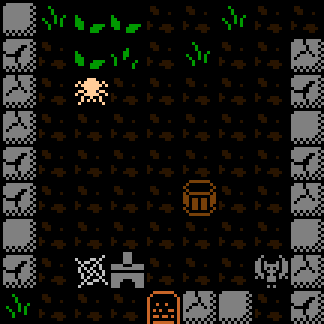

In [ ]:
uz.vg_tiled(Map, scale=3, show=True, filepath=None)


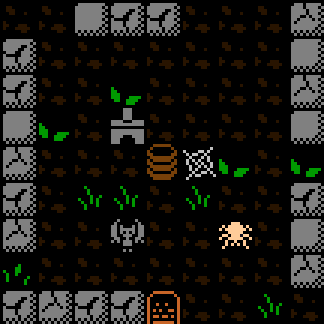

In [ ]:
import io
import numpy as np
import time
import base64
import matplotlib.pyplot as plt
import IPython

def fig2b64(f):
  # data = io.BytesIO()
  # f.savefig(data, format='png')
  # data.seek(0)
  # return base64.b64encode(data.read()).decode()
  # buffered = io.BytesIO()
  # a.save(buffered, format='png')
  # return base64.b64encode(buffered.getvalue())
  data = io.BytesIO()
  a.save(data, format='png')
  data.seek(0)
  return base64.b64encode(data.read()).decode()

f = plt.figure(num=1, clear=True)
x = np.arange(10)
y = np.arange(10)
line = f.gca().plot(x, y)[0]

data_str = fig2b64(f)

IPython.display.display_html(f'<img class="myimage" src="data:image/png;base64,{data_str}"></img>', raw=True)

for _ in range(10):
  time.sleep(0.3)
  np.random.shuffle(y)
  line.set_data(x, y)
  data_str = fig2b64(f)
  IPython.display.display_javascript(f'''
    document.querySelector('.myimage').src = 'data:image/png;base64,{data_str}';
  ''', raw=True)

# suppress final output
plt.close(1)

In [ ]:
# Neural network
# Predict the level you will go to with current equipment
# Advise a player with next steps
# Complete it by itself, like mario, no death

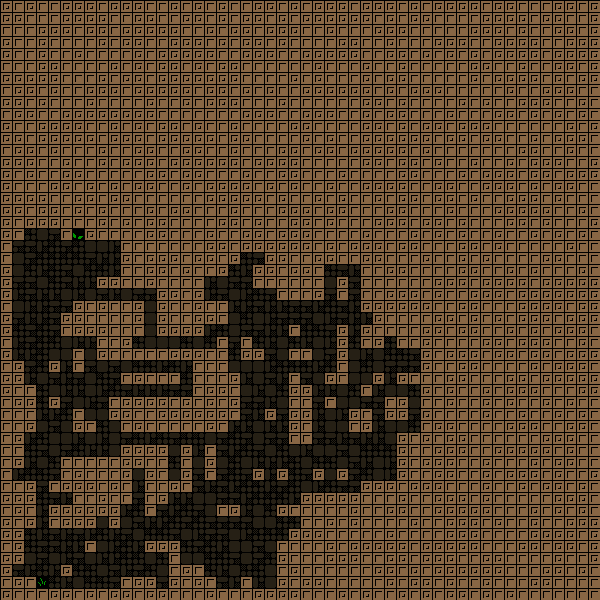

In [ ]:
# player = Map.cells[0][0]
# enemy = Map.cells[0][0]

# p = player_start_coords(M)
# e = enemy_start_coords(M)
# M.cells[p[0]][p[1]].actors = [player]
# M.cells[e[0]][e[1]].actors = [enemy]
# uz.vg_tiled(M, scale=1)

In [ ]:
import io
import numpy as np
import time
import base64
import matplotlib.pyplot as plt
import IPython

class Painter:
  def _fig2b64(self, img):
    data = io.BytesIO()
    img.save(data, format='png')
    data.seek(0)
    return base64.b64encode(data.read()).decode()

  def draw_init(self, img):
    data_str = self._fig2b64(img)
    IPython.display.display_html(f'<img class="myimage" src="data:image/png;base64,{data_str}"></img>', raw=True)

  def draw_step(self, img):
    data_str = self._fig2b64(img)
    IPython.display.display_javascript(f'''
        document.querySelector('.myimage').src = 'data:image/png;base64,{data_str}';
    ''', raw=True)

In [ ]:
from copy import copy, deepcopy

class Game:
  def __init__(self, map):
    self.map = map
    self.p = self._player_start_coords(map)
    self.e = self._enemy_start_coords(map)
    self._convert_to_array()
    self.n_steps = 0

  def _convert_to_array(self):
    self.arr = []
    for y in range(len(self.map.cells)):
      self.arr.append([])
      for x in range(len(self.map.cells[y])):
        self.arr[y].append(1 if 'wall' in self.map.cells[y][x].metatile.tags else 0)

  def _place_on_map(self):
    new_arr = deepcopy(self.arr)
    new_arr[self.p[0]][self.p[1]] = 500
    new_arr[self.e[0]][self.e[1]] = 999
    return new_arr

  def reset(self):
    self.p = self._player_start_coords(self.map)
    self.e = self._enemy_start_coords(self.map)
    self._convert_to_array()
    self.n_steps = 0
    return self._place_on_map()

  def _player_start_coords(self, m):
    for y in range(len(m.cells) - 1, -1, -1):
      for x in range(len(m.cells[y])):
        if 'floor' in m.cells[y][x].metatile.tags:
          return [y, x]

  def _enemy_start_coords(self, m):
    for y in range(len(m.cells)):
      for x in range(len(m.cells[y]) - 1, -1, -1):
        if 'floor' in m.cells[y][x].metatile.tags:
          return [y, x]

  def _manh_dist(self, p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

  def step(self, move):
    reward = 0
    done = False

    prev = self.p.copy()

    if move == 0:
      if self.arr[self.p[0] - 1][self.p[1]] == 0:
        self.p[0] -= 1
      else:
        reward = 0
    elif move == 1:
      if self.arr[self.p[0] + 1][self.p[1]] == 0:
        self.p[0] += 1
      else:
        reward = 0
    elif move == 2:
      if self.arr[self.p[0]][self.p[1] - 1] == 0:
        self.p[1] -= 1
      else:
        reward = 0
    elif move == 3:
      if self.arr[self.p[0]][self.p[1] + 1] == 0:
        self.p[1] += 1
      else:
        reward = 0

    if self.p[0] == self.e[0] and self.p[1] == self.e[1]:
      reward = 1000
      done = True
    else:
      reward = self._manh_dist(prev, self.e) - self._manh_dist(self.p, self.e)

    self.n_steps += 1

    return self._place_on_map(), reward, done, {}

  def render_image(self):
    self.map.cells[self.p[0]][self.p[1]].actors = [player]
    self.map.cells[self.e[0]][self.e[1]].actors = [enemy]
    render = uz.vg_tiled(self.map, scale=2, show=False, filepath=None)

    self.map.cells[self.p[0]][self.p[1]].actors = []
    self.map.cells[self.e[0]][self.e[1]].actors = []

    return render


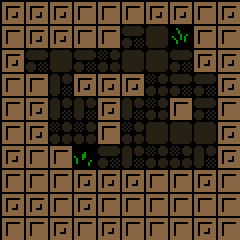

Episode 1/1000, Total Reward: 1008


Exception ignored in: <function _xla_gc_callback at 0x786656be8790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import random
from collections import deque

# Hyperparameters
state_size = (M.h, M.w)  # Example state size
action_size = 4  # Up, Down, Left, Right
batch_size = 32
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
# epsilon_decay = 1
learning_rate = 0.01
episodes = 1000

# Define the Q-network
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=state_size + (1,)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
    return model

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Initialize the environment (replace with your game environment)
# For demonstration, we use a random environment.
env = Game(M)

painter = Painter()
painter.draw_init(env.render_image())

# Initialize replay buffer and Q-network
replay_buffer = ReplayBuffer(max_size=2000)
model = build_model()

# Training loop
for episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1] + list(state_size))
    done = False
    total_reward = 0

    while not done:
        # Choose action
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            # print('my chose')
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values[0])

        # Take action
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1] + list(state_size))
        # print(action)
        # print(env.p[0], env.p[1])

        painter.draw_step(env.render_image())

        # Store experience
        replay_buffer.add((state, action, reward, next_state, done))

        # Update state
        state = next_state
        total_reward += reward

        if len(replay_buffer.buffer) > batch_size:
            minibatch = replay_buffer.sample(batch_size)
            states = np.vstack([s[0] for s in minibatch])
            actions = np.array([s[1] for s in minibatch])
            rewards = np.array([s[2] for s in minibatch])
            next_states = np.vstack([s[3] for s in minibatch])
            dones = np.array([s[4] for s in minibatch])

            # Predict Q-values for next states in batch
            q_next = model.predict(next_states, verbose=0)
            q_targets = rewards + gamma * np.amax(q_next, axis=1) * (1 - dones)

            # Predict Q-values for current states in batch
            q_values = model.predict(states, verbose=0)
            for i in range(batch_size):
                q_values[i][actions[i]] = q_targets[i]

            # Train the model
            model.fit(states, q_values, epochs=1, verbose=0)

        # Decrease epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

env.close()
